# Лабораторная работа №6
### Построение общей модели на основе случайных полей и статической модели блокировки
## Цель:
Ознакомление с общей моделью на основе случайных полей и статической модели
блокировки.

## Задание
В круге радиуса R, центром которого является целевой приемник,
распределены согласно Пуассоновскому равномерному точечному процессу с
интенсивностью B интерферирующие устройства. На целевом приемнике
расположена всенаправленная антенна, а интерферирующие устройства
оборудованы направленными антеннами с углом диаграммы направленности γ.
Предполагается, что все антенны сориентированы случайным образом и постоянно
излучают сигнал с мощностью P. При этом применяется модель распространения
сигнала Cone (аналог модели Free Space Path Loss с поправкой на коэффициент
диаграммы направленности). В этом же круге согласно Пуассоновскому
равномерному точечному процессу с интенсивностью A распределены
блокирующие объекты радиуса D. Для упрощения интерферирующие устройства не
считать блокирующими объектами.

В случае если сигнал от интерферирующего передатчика до целевого
приемника проходит через блокирующий объект, то он не создает помех на целевом
приемнике. Аналогично, если целевой приемник не попадает в сектор диаграммы
направленности интерферирующего передатчика, то соответствующий
интерферирующий сигнал тоже не создает помех.
На основе полученной модели построить графики среднего значения
интерференции как функции от направленности антенн γ, интенсивности
Пуассоновского поля источников интерферирующих устройств B, интенсивности
Пуассоновского поля блокирующих объектов A. При построении графиков
использовать как минимум 1000 реализаций.

In [157]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

Начальные значения для модели:
```
    Rx_r = Радиус большого поля
    lambda0_block = Лямбда пуассона для блокираторов
    lambda0_I = Лямбда пуассона для объектов
    areaTotal = Площадь круга
    circle_radius = радиус блокаторов

    angl_phi = размер угла видимости у объектов
    ang_dist = расстояние линий угла (для отрисовки)

    Power = Мощность
```

In [158]:
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3

angl_phi = np.pi / 3
ang_dist = 1

Power = 1

In [159]:
def G(phi):
    return 2/(1-np.cos(phi/2))

def PRx(power, Rx_Ii_d, phi):
    return power * G(phi) / (4*np.pi * Rx_Ii_d**2)

In [160]:
def plot_circle(x,y,r):
    angels = np.linspace(0,2*np.pi,50)
    cirX = x+r*np.cos(angels)
    cirY = y+r*np.sin(angels)
    plt.plot(cirX, cirY, "r")

In [161]:
def plot_angl(x1,y1, rand_angl, draw=True, ret=False):
    x2 = x1 + ang_dist * np.cos(rand_angl)
    y2 = y1 + ang_dist * np.sin(rand_angl)
    x3 = x1 + ang_dist * np.cos(rand_angl + angl_phi)
    y3 = y1 + ang_dist * np.sin(rand_angl + angl_phi)
    if draw:
        plt.plot([x1,x2], [y1,y2], "--m", )
        plt.plot([x1,x3], [y1,y3], "--m", )
        if ret:
            return (x2,y2), (x3,y3)
    else:
        return (x2,y2), (x3,y3)

In [162]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [163]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [164]:
def poisson_circle_points(l,area, r):
    numbPoints = np.random.poisson(l*areaTotal)
    phi=2*np.pi*np.random.uniform(0,1,numbPoints)
    rho=r*np.sqrt(np.random.uniform(0,1,numbPoints))

    X,Y = pol2cart(rho, phi)
    return X, Y

In [165]:
def check_dist(a,b,c):
    ca = (c-a) / norm(c-a)
    ba = (b-a) / norm(b-a)
    cb = (c-b) / norm(c-b)
    ab = (a-b) / norm(a-b)
    
    if np.arccos(np.dot(ca,ba)) > 1:
        return norm(c-a)
    if np.arccos(np.dot(cb,ab)) > 1:
        return norm(c-b)
    return norm(np.cross(a-b, a-c)) / norm(b-a)

In [166]:
def iscrossing(x_c:dict, y_c:dict, dot1:[tuple,dict], dot2:[tuple,dict]) -> bool:
    for i in range(len(x_c)):
        if np.round(check_dist(np.array(dot1),np.array(dot2),np.array([x_c[i], y_c[i]])), 1) <= circle_radius:
            return True
    return False

In [167]:
def check_visibility(dm: [tuple,dict], dfv: [tuple,dict], dsv: [tuple,dict]) -> bool:
    
    rad1 = cart2pol(dfv[0]-dm[0], dfv[1]-dm[1])[1]
    rad2 = cart2pol(0-dm[0], 0-dm[1])[1]
    rad3 = cart2pol(dsv[0]-dm[0], dsv[1]-dm[1])[1]
    
    r1 = rad1 if rad1 >= 0 else rad1 + np.pi*2
    g1 = rad2 if rad2 >= 0 else rad2 + np.pi*2
    b1 = rad3 if rad3 >= 0 else rad3 + np.pi*2
    
    if g1 > r1 and g1 < b1:
        return True
    else:
        return False

отрисовка модели

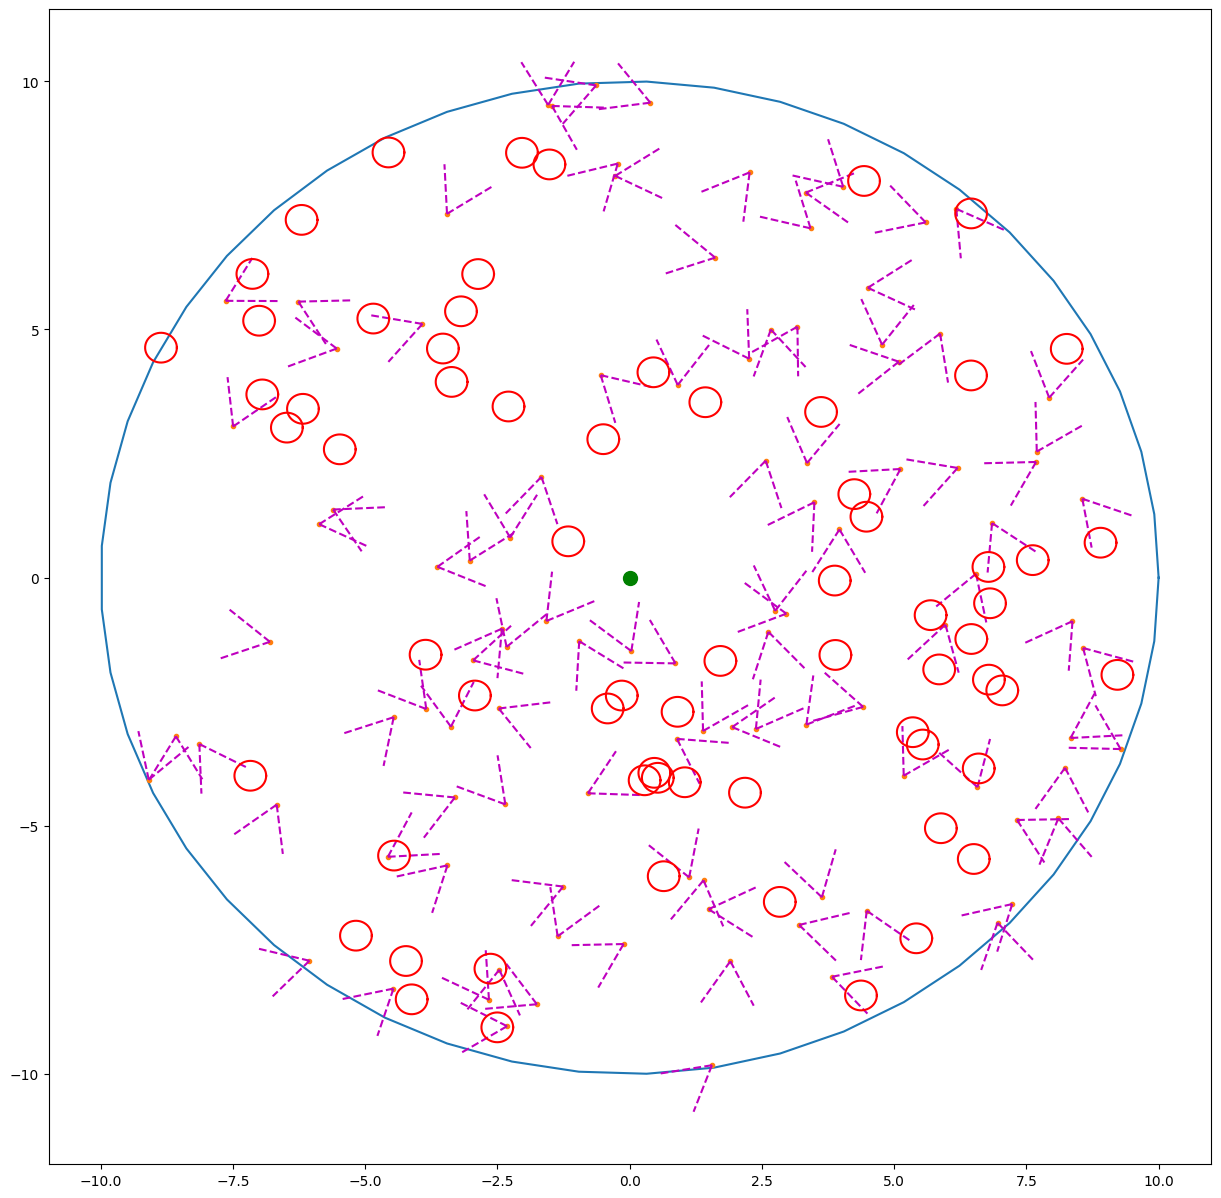

In [168]:
X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal, Rx_r)
X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)

plt.figure(figsize=(15,15))

angels = np.linspace(0,2*np.pi,50)
cirX = Rx_r*np.cos(angels)
cirY = Rx_r*np.sin(angels)
plt.plot(cirX,cirY)

plt.plot(X_I, Y_I, ".")

Dots_F = []
Dots_S = []
for i,j in zip(X_I,Y_I):
    dot1,dot2 = plot_angl(i,j,np.random.uniform(0, 2*np.pi), ret=True)
    Dots_F.append(dot1)
    Dots_S.append(dot2)


plt.plot(0,0,'.g',markersize=20)

for i in range(len(X_c)):
    plot_circle(X_c[i], Y_c[i], circle_radius)

In [169]:
cnt = 0
for xi, yi in zip(X_I,Y_I):
    dot_i = (xi, yi)
    if iscrossing(X_c, Y_c, dot_i, (0,0)):
        cnt+=1
print("{} obj IS blocked out of {}".format(cnt, len(X_I)))

67 obj IS blocked out of 106


In [170]:
cnt = 0
for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
    dot_main = (xi, yi)
    if check_visibility(dot_main, dot1, dot2):
        cnt += 1
print("{} obg can see modtager out of {}".format(cnt, len(X_I)))

15 obg can see modtager out of 106


In [171]:
cnt = 0
for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
        dot_main = (xi, yi)
        if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
            cnt+=1
print("{} obg CAN see modtager AND NOT blocked out of {}".format(cnt, len(X_I)))

6 obg CAN see modtager AND NOT blocked out of 106


построение графиков

In [172]:

Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1


phi_list = np.linspace(.01,np.pi-.01,10) 
N = 1000 

Imean=[]
CNT_list = []

for p in phi_list:
    I_list = []
    models_cnt = []
    for _ in range(N):
        X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)
        
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, p, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                CNT+=1
                distance = np.sqrt((xi)**2 + (yi)**2)
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

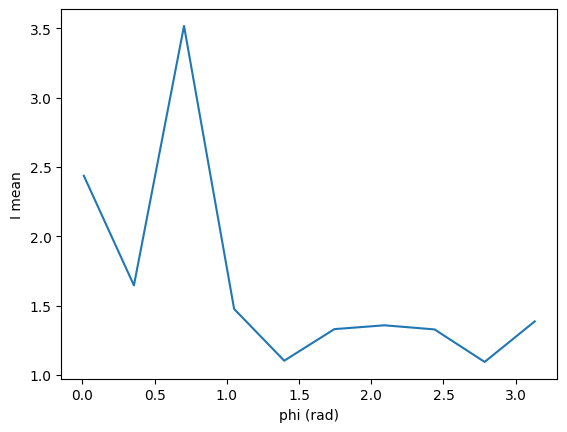

In [173]:
plt.plot(phi_list, Imean)
plt.xlabel("phi (rad)")
plt.ylabel("I mean")

In [179]:
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1

lambda_I = np.linspace(.01, .5, 10) 
N = 1000

Imean=[]
CNT_list = []

for lll in lambda_I:
    I_list = []
    models_cnt = []
    for _ in range(N):
        X_I,Y_I = poisson_circle_points(lll, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)
        
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, angl_phi, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                CNT+=1
                distance = np.sqrt((xi)**2 + (yi)**2)
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

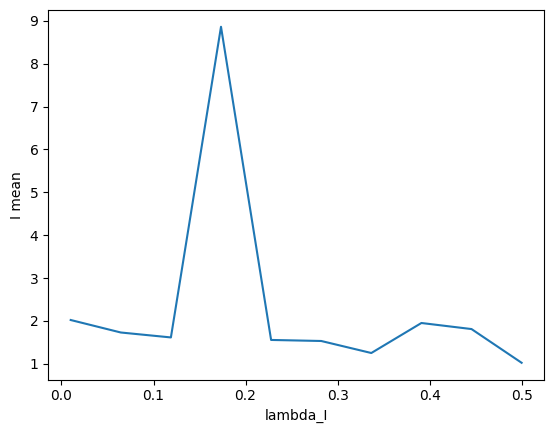

In [181]:
plt.plot(lambda_I, Imean)
plt.xlabel("lambda_I")
plt.ylabel("I mean")

In [180]:
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1

lambda_block = np.linspace(.01, .5, 10)
N = 1000

Imean=[]
CNT_list = []

for lll in lambda_block:
    I_list = []
    models_cnt = []
    for _ in range(N):
        X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lll, areaTotal,Rx_r)
        
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, angl_phi, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                CNT+=1
                distance = np.sqrt((xi)**2 + (yi)**2)
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

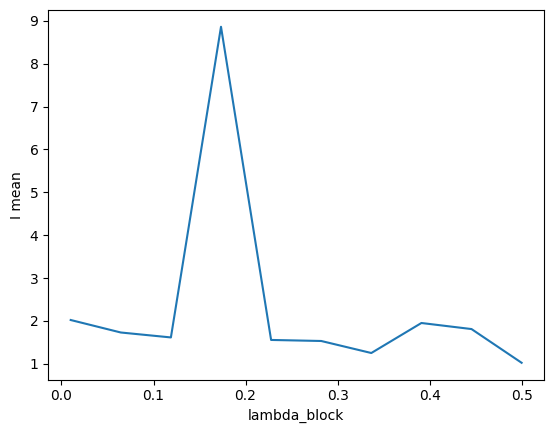

In [185]:
plt.plot(lambda_block, Imean)
plt.xlabel("lambda_block")
plt.ylabel("I mean")